In [2]:
## Importing Libraries

import cv2
import os
import time
import torch
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import load_model

from random import randint
from pathlib import Path
from PIL import Image
import PIL.Image
from scipy.io import loadmat
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import torchvision.models as models
from matplotlib.ticker import FormatStrFormatter
import matplotlib.image as mpimg
from matplotlib.pyplot import imshow
from IPython.display import Image

In [3]:
capstone_data_path = "./Data"

train_data_path = "./Data/Car-Images/Train Images"
test_data_path = "./Data/Car-Images/Test Images"

processed_train_dir_path = "./Data/Car-Images/Processed-Train-Images"
processed_train_validation_dir_path = "./Data/Car-Images/Processed-Validation-Images"

processed_test_dir_path = "./Data/Car-Images/Processed-Test-Images"
bounded_test_dir_path = "./Data/Car-Images/Bounded-Test-Images"

In [4]:
import os

## Data in Training Folder
## Walk through the Cars directory and list number of files

totalImages = 0
for dirpath, dirnames, filenames in os.walk(train_data_path):
#     print(f"There are {len(dirnames)} directories and len {len(filenames)} images in '{dirpath}'.")
    totalImages += len(filenames)
print("\nTotal Images in training set are:", totalImages)


Total Images in training set are: 8144


In [5]:
# Let's visualize our images

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def view_random_image(target_dir, target_class):
    # Setup the target directory (we'll view images from here)
    target_folder = target_dir + target_class
    
    random_image = random.sample(os.listdir(target_folder), 1)
    print(random_image)
    
    # Read in the image and plot it using matplotlib
    img = mpimg.imread(target_folder + "/" + random_image[0])
    plt.imshow(img)
    plt.title(target_class)
    plt.axis("off");
    
    print(f"Image shape: {img.shape}") # show the shape of the image
    
    return img

['00691.jpg']
Image shape: (450, 600, 3)


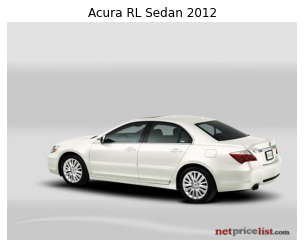

In [6]:
# View the random image from the training dataset

img = view_random_image(target_dir=train_data_path + "/", target_class="Acura RL Sedan 2012")

In [7]:
## Load Class Names

car_names = pd.read_csv(capstone_data_path + '/Car-Names.csv', header=None)
car_names.columns = ['Car']
car_names.head(10)

Car
0                AM General Hummer SUV 2000
1                       Acura RL Sedan 2012
2                       Acura TL Sedan 2012
3                      Acura TL Type-S 2008
4                      Acura TSX Sedan 2012
5                 Acura Integra Type R 2001
6                  Acura ZDX Hatchback 2012
7  Aston Martin V8 Vantage Convertible 2012
8        Aston Martin V8 Vantage Coupe 2012
9      Aston Martin Virage Convertible 2012

In [8]:
## Load Train Annotations

train_data_annotations = pd.read_csv(capstone_data_path + '/Train-Annotations.csv')
print("Shape of Train Annotations", train_data_annotations.shape)
train_data_annotations.head(10)

Shape of Train Annotations (8144, 6)


Image Name  Bounding Box coordinates  Unnamed: 2  Unnamed: 3  Unnamed: 4  \
0  00001.jpg                        39         116         569         375   
1  00002.jpg                        36         116         868         587   
2  00003.jpg                        85         109         601         381   
3  00004.jpg                       621         393        1484        1096   
4  00005.jpg                        14          36         133          99   
5  00006.jpg                       259         289         515         416   
6  00007.jpg                        88          80         541         397   
7  00008.jpg                        73          79         591         410   
8  00009.jpg                        20         126        1269         771   
9  00010.jpg                        21         110         623         367   

   Image class  
0           14  
1            3  
2           91  
3          134  
4          106  
5          123  
6           89  
7           96  
8          167  
9           58

In [9]:
## Counting not null values
train_data_annotations.isna().sum()

Image Name                  0
Bounding Box coordinates    0
Unnamed: 2                  0
Unnamed: 3                  0
Unnamed: 4                  0
Image class                 0
dtype: int64

In [10]:
# Create Dictionary of Classes

classDictionary = {}
count = 1
term = 0

for index, series in car_names.iterrows():
    classDictionary.update({count:series['Car']})
    count = count + 1

term = 0
for num, model in classDictionary.items():
    if '/' in model:
        model = model.replace("/", "-")
        classDictionary[num] = model
    term = term + 1
print('...')

classDictionary

...


{1: 'AM General Hummer SUV 2000',
 2: 'Acura RL Sedan 2012',
 3: 'Acura TL Sedan 2012',
 4: 'Acura TL Type-S 2008',
 5: 'Acura TSX Sedan 2012',
 6: 'Acura Integra Type R 2001',
 7: 'Acura ZDX Hatchback 2012',
 8: 'Aston Martin V8 Vantage Convertible 2012',
 9: 'Aston Martin V8 Vantage Coupe 2012',
 10: 'Aston Martin Virage Convertible 2012',
 11: 'Aston Martin Virage Coupe 2012',
 12: 'Audi RS 4 Convertible 2008',
 13: 'Audi A5 Coupe 2012',
 14: 'Audi TTS Coupe 2012',
 15: 'Audi R8 Coupe 2012',
 16: 'Audi V8 Sedan 1994',
 17: 'Audi 100 Sedan 1994',
 18: 'Audi 100 Wagon 1994',
 19: 'Audi TT Hatchback 2011',
 20: 'Audi S6 Sedan 2011',
 21: 'Audi S5 Convertible 2012',
 22: 'Audi S5 Coupe 2012',
 23: 'Audi S4 Sedan 2012',
 24: 'Audi S4 Sedan 2007',
 25: 'Audi TT RS Coupe 2012',
 26: 'BMW ActiveHybrid 5 Sedan 2012',
 27: 'BMW 1 Series Convertible 2012',
 28: 'BMW 1 Series Coupe 2012',
 29: 'BMW 3 Series Sedan 2012',
 30: 'BMW 3 Series Wagon 2012',
 31: 'BMW 6 Series Convertible 2007',
 32: 

In [11]:
## Rename Labels for Training Annotations

columns = ['Image_name','x1', 'y1', 'x2', 'y2', 'Image_class']
train_data_annotations.columns = columns
train_data_annotations.head()

Image_name   x1   y1    x2    y2  Image_class
0  00001.jpg   39  116   569   375           14
1  00002.jpg   36  116   868   587            3
2  00003.jpg   85  109   601   381           91
3  00004.jpg  621  393  1484  1096          134
4  00005.jpg   14   36   133    99          106

In [12]:
## Load Test Annotations

test_data_annotations = pd.read_csv(capstone_data_path + '/Test-Annotations.csv')
test_data_annotations.columns = columns
test_data_annotations.head()

Image_name   x1   y1   x2   y2  Image_class
0  00001.jpg   30   52  246  147          181
1  00002.jpg  100   19  576  203          103
2  00003.jpg   51  105  968  659          145
3  00004.jpg   67   84  581  407          187
4  00005.jpg  140  151  593  339          185

In [13]:
## Step 1: Map training to its classes
## Creating a dataframe for training images

def data_labelling(data_path):
    label = []
    path = []
    lbCat = 0
    for dir_name, _,filenames in os.walk(data_path):
        for filename in filenames:
            if os.path.splitext(filename)[1]=='.jpg':
                label.append(os.path.split(dir_name)[1])
                path.append(os.path.join(dir_name,filename)) 
        lbCat = lbCat + 1
    
    data = pd.DataFrame(columns=['path','label'])
    data['path'] = path
    data['label'] = label
    return data

In [14]:
train_data = data_labelling(train_data_path)
# train_data.head(50)

In [15]:
# Function to show images according to the given dataset
def show_images(data):
    fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(15,9), constrained_layout=True)
    ax = ax.flatten()

    idx = 0
    for i in data['label'].unique():
        if(idx==9):
            break;
        ax[idx].imshow(plt.imread(data[data['label']==i].iloc[0,0]))
        ax[idx].set_title(i)
        idx = idx+1

Train data Images with Labels


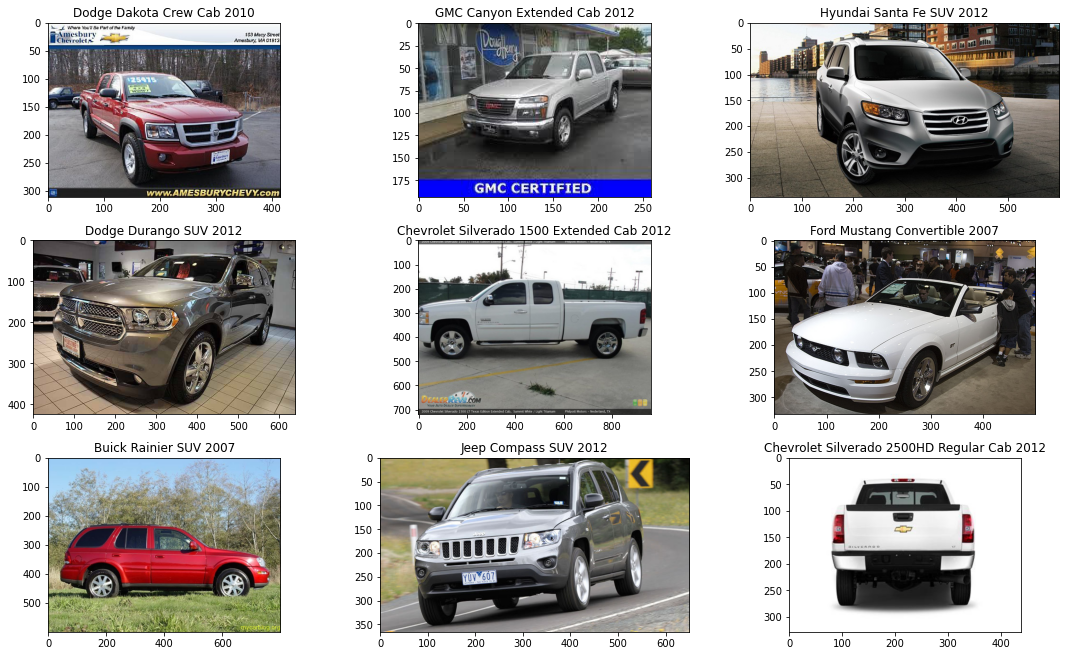

In [16]:
train_data = data_labelling(train_data_path)

print("Train data Images with Labels")
show_images(train_data)

Test data Images with Labels


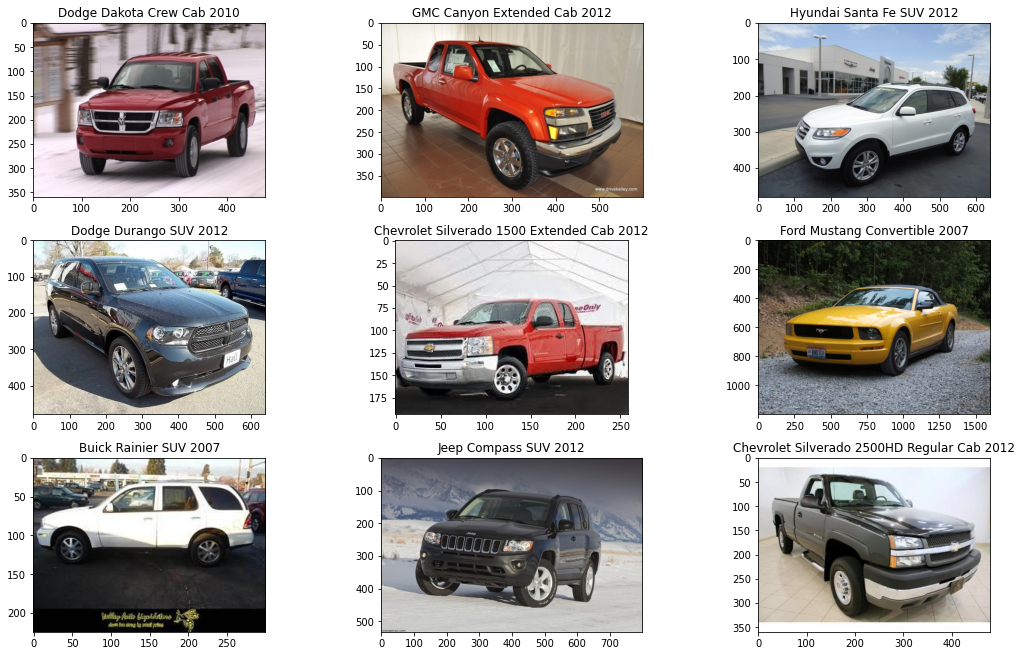

In [17]:
test_data = data_labelling(test_data_path)

print("Test data Images with Labels")
show_images(test_data)

In [18]:
## Annotate Images with Bounding Boxes

bounding_box_annotations = train_data_annotations.drop("Image_class", axis=1)
bounding_box_annotations.head()

Image_name   x1   y1    x2    y2
0  00001.jpg   39  116   569   375
1  00002.jpg   36  116   868   587
2  00003.jpg   85  109   601   381
3  00004.jpg  621  393  1484  1096
4  00005.jpg   14   36   133    99

In [19]:
# Bounding Box Function 

def map_bounding_box(start_point, end_point, sample_image):
    color = (255, 0, 0)     
    thickness = 2
    image = cv2.rectangle(sample_image, start_point, end_point, color, thickness)
    return image

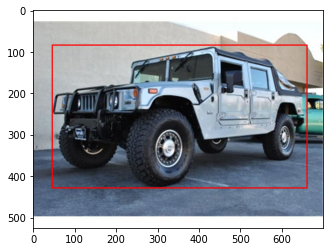

In [20]:
## Drawing bounding box for a Sample Image

random_image_annotations = bounding_box_annotations.loc[bounding_box_annotations['Image_name']=='00163.jpg']
random_annotations = random_image_annotations.values.tolist()[0]

random_img_path = train_data_path + "/AM General Hummer SUV 2000/00163.jpg"

## 1. Read Image from Image Path
image = mpimg.imread(random_img_path)

start_point = (random_annotations[1], random_annotations[2])
end_point = (random_annotations[3], random_annotations[4])

image = map_bounding_box(start_point, end_point, image)

## Random Image with Bounding Box
plt.imshow(image)

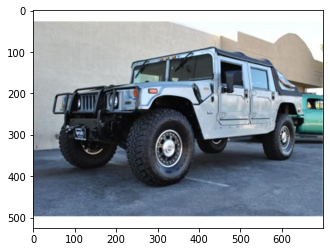

In [21]:
## Random Image without Bounding Box
img = mpimg.imread(random_img_path)
plt.imshow(img)

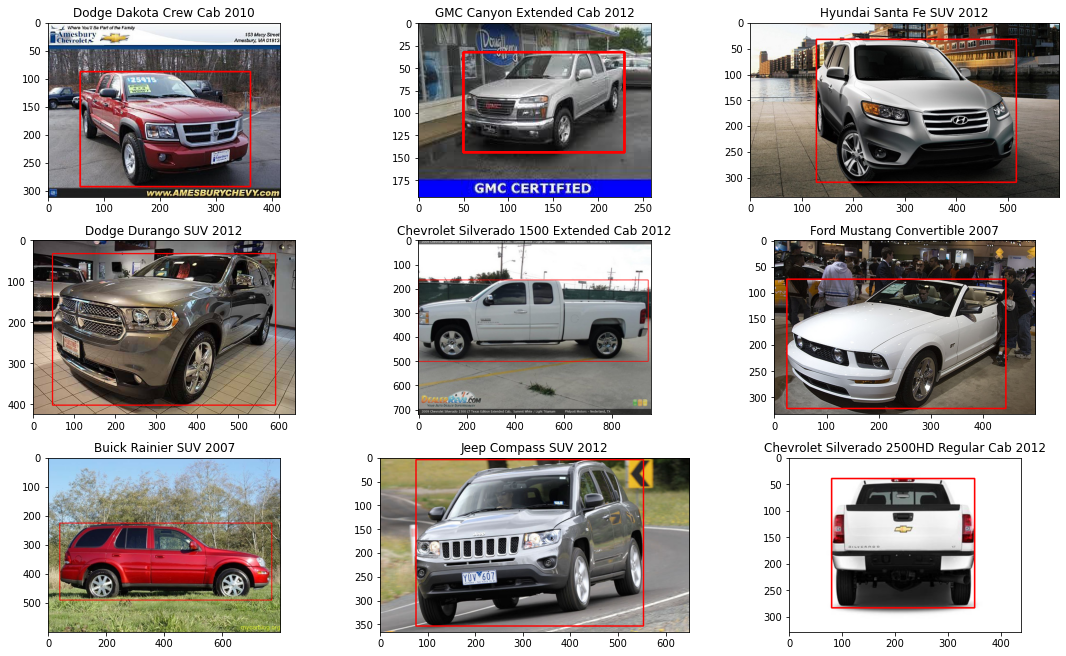

In [22]:
# Bounding Box on Images

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(15,9), constrained_layout=True)
ax = ax.flatten()

idx = 0
j=0
for i in train_data['label'].unique():
    if(idx==9):
        break;
    image_path = train_data[train_data['label']==i].iloc[0,0]
    for image_name in image_path.split("/"):
        if ".jpg" in image_name:
            bounding_box = train_data_annotations[(train_data_annotations['Image_name'] == image_name)].iloc[:,1:5].values
            start_point = tuple(bounding_box[0][:2])
            end_point = tuple(bounding_box[0][2:])
            image = plt.imread(image_path)
            images = map_bounding_box(start_point,end_point,image)
            ax[idx].imshow(images)
            ax[idx].set_title(i)
    idx = idx+1

In [154]:
trainLabels = train_data_annotations.to_numpy()
testLabels = test_data_annotations.to_numpy()

In [157]:
np.save('testLabels', testLabels)

In [24]:
for i in range(len(trainLabels) - 4, len(trainLabels)):
    print(trainLabels[i])

['08141.jpg' 138 150 706 523 196]
['08142.jpg' 26 246 660 449 163]
['08143.jpg' 78 526 1489 908 112]
['08144.jpg' 20 240 862 677 17]


In [25]:
trainLabels

array([['00001.jpg', 39, 116, 569, 375, 14],
       ['00002.jpg', 36, 116, 868, 587, 3],
       ['00003.jpg', 85, 109, 601, 381, 91],
       ...,
       ['08142.jpg', 26, 246, 660, 449, 163],
       ['08143.jpg', 78, 526, 1489, 908, 112],
       ['08144.jpg', 20, 240, 862, 677, 17]], dtype=object)

### Pre Process Images with Annotations

In [26]:
## Pre-Processing Training Data

print(len(trainLabels), "Images to Process.")

Path(processed_train_dir_path).mkdir(parents=True, exist_ok=True)
Path(processed_train_validation_dir_path).mkdir(parents=True, exist_ok=True)

count = 1
for l in trainLabels:
    print("Processing Image #", count, 'of', len(trainLabels))
    
    # Bounding Box coordinates
    x1 = l[1]
    y1 = l[2]
    x2 = l[3]
    y2 = l[4]
    class_num = l[5]
    fileName = l[0]
    classAppend = classDictionary.get(class_num) + '/'
    address = train_data_path + "/" + classAppend + fileName
    if count < 7000:
        saveDir = processed_train_dir_path + "/" + classAppend
    else:
        saveDir = processed_train_validation_dir_path + "/" + classAppend
    im = PIL.Image.open(address)
    region = im.crop((x1,y1,x2,y2))
    Path(saveDir).mkdir(parents=True, exist_ok=True)
    saveAddress = saveDir + fileName
    region.save(saveAddress)
    print("Image Saved",saveAddress)
    count = count + 1

print("----------------------------------------")
print("Training Images preprocessing complete.!")

8144 Images to Process.
Processing Image # 1 of 8144
Image Saved ./Data/Car-Images/Processed-Train-Images/Audi TTS Coupe 2012/00001.jpg
Processing Image # 2 of 8144
Image Saved ./Data/Car-Images/Processed-Train-Images/Acura TL Sedan 2012/00002.jpg
Processing Image # 3 of 8144
Image Saved ./Data/Car-Images/Processed-Train-Images/Dodge Dakota Club Cab 2007/00003.jpg
Processing Image # 4 of 8144
Image Saved ./Data/Car-Images/Processed-Train-Images/Hyundai Sonata Hybrid Sedan 2012/00004.jpg
Processing Image # 5 of 8144
Image Saved ./Data/Car-Images/Processed-Train-Images/Ford F-450 Super Duty Crew Cab 2012/00005.jpg
Processing Image # 6 of 8144
Image Saved ./Data/Car-Images/Processed-Train-Images/Geo Metro Convertible 1993/00006.jpg
Processing Image # 7 of 8144
Image Saved ./Data/Car-Images/Processed-Train-Images/Dodge Journey SUV 2012/00007.jpg
Processing Image # 8 of 8144
Image Saved ./Data/Car-Images/Processed-Train-Images/Dodge Charger Sedan 2012/00008.jpg
Processing Image # 9 of 8144


In [27]:
## Pre-processing Test Images

print(len(testLabels), "Images to Process.")

Path(processed_test_dir_path).mkdir(parents=True, exist_ok=True)
Path(bounded_test_dir_path).mkdir(parents=True, exist_ok=True)

count = 1
for l in testLabels:
    print("Processing Image #", count, 'of', len(testLabels))

    # Bounding Box coordinates
    x1 = l[1]
    y1 = l[2]
    x2 = l[3]
    y2 = l[4]
    class_num = l[5]
    fileName = l[0]
    classAppend = classDictionary.get(class_num) + '/'
    address = test_data_path + "/" + classAppend + fileName
    saveDir = processed_test_dir_path + "/" + classAppend
    im = PIL.Image.open(address)
    region = im.crop((x1, y1, x2, y2))
    Path(saveDir).mkdir(parents=True, exist_ok=True)
    saveAddress = saveDir + fileName
    saveAddress2 = bounded_test_dir_path + "/" + fileName
    region.save(saveAddress2)    
    print('Bounded Image Saved:', saveAddress2)
    region.save(saveAddress)    
    print('Processed Test Image Saved:', saveAddress)
    count = count + 1

print("----------------------------------------")
print("Test Images preprocessing complete.!")

8041 Images to Process.
Processing Image # 1 of 8041
Bounded Image Saved: ./Data/Car-Images/Bounded-Test-Images/00001.jpg
Processed Test Image Saved: ./Data/Car-Images/Processed-Test-Images/Suzuki Aerio Sedan 2007/00001.jpg
Processing Image # 2 of 8041
Bounded Image Saved: ./Data/Car-Images/Bounded-Test-Images/00002.jpg
Processed Test Image Saved: ./Data/Car-Images/Processed-Test-Images/Ferrari 458 Italia Convertible 2012/00002.jpg
Processing Image # 3 of 8041
Bounded Image Saved: ./Data/Car-Images/Bounded-Test-Images/00003.jpg
Processed Test Image Saved: ./Data/Car-Images/Processed-Test-Images/Jeep Patriot SUV 2012/00003.jpg
Processing Image # 4 of 8041
Bounded Image Saved: ./Data/Car-Images/Bounded-Test-Images/00004.jpg
Processed Test Image Saved: ./Data/Car-Images/Processed-Test-Images/Toyota Camry Sedan 2012/00004.jpg
Processing Image # 5 of 8041
Bounded Image Saved: ./Data/Car-Images/Bounded-Test-Images/00005.jpg
Processed Test Image Saved: ./Data/Car-Images/Processed-Test-Images/

['06061.jpg']
Image shape: (1236, 2000, 3)


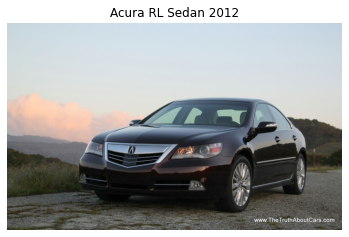

In [72]:
## Original Train Image - Randomly Selected

img = view_random_image(target_dir=train_data_path + "/", target_class="Acura RL Sedan 2012")

['06061.jpg']
Image shape: (685, 1371, 3)


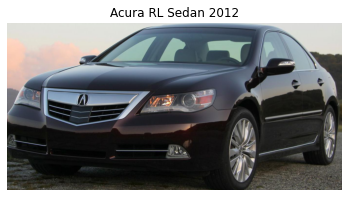

In [60]:
## Processed Train Image

img = view_random_image(target_dir=processed_train_dir_path + "/", target_class="Acura RL Sedan 2012")

['05834.jpg']
Image shape: (768, 1024, 3)


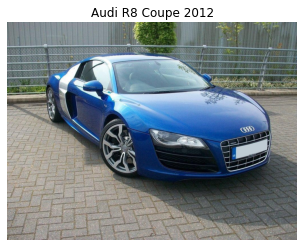

In [73]:
## Original Test Random Image

img = view_random_image(target_dir=test_data_path + "/", target_class="Audi R8 Coupe 2012")

['05834.jpg']
Image shape: (442, 797, 3)


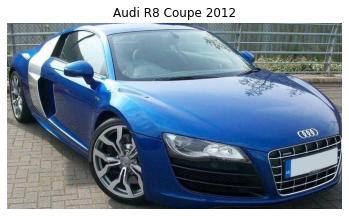

In [83]:
## Processed Test Random Image from the same class

img = view_random_image(target_dir=processed_test_dir_path + "/", target_class="Audi R8 Coupe 2012")

In [ ]:
# Transform and load the processed data

def getTrainTransformedData(directory):
    data = datasets.ImageFolder(directory, 
                                transform = transforms.Compose([transforms.Resize((244,244)),
                                transforms.RandomRotation(30),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))
    return torch.utils.data.DataLoader(data, batch_size=128, shuffle=True)

def getTestTransformedData(directory):
    data = datasets.ImageFolder(directory,
                                transform = transforms.Compose([transforms.Resize((244,244)),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))
    return torch.utils.data.DataLoader(data, batch_size=32, shuffle=True)

In [89]:
trainLoad = getTrainTransformedData(processed_train_dir_path)
validLoad = getTestTransformedData(processed_train_validation_dir_path)
testLoad = getTestTransformedData(processed_test_dir_path)

In [90]:
model = models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 196)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
lrscheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, threshold = 0.9)

In [91]:
model.parameters

<bound method Module.parameters of ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 2

In [93]:
start = time.time()
epochs = 10
iterations = 0
val = 35
model.train()

def validation(model, validloader, criterion):
    valid_loss = 0
    accuracy = 0
    for i, (images, labels) in enumerate(validloader):
        output = model.forward(images)
        valid_loss = valid_loss + criterion(output, labels).item()
        ps = torch.exp(output)
        equality = (labels.data == ps.max(dim=1)[1])
        accuracy = accuracy + equality.type(torch.FloatTensor).mean()
    return valid_loss, accuracy

v_loss_hist = list()
tr_loss_hist = list()
v_acc_hist = list()

for e in range(epochs):
    running_loss = 0
    for i, (inputs, labels) in enumerate(trainLoad):
        iterations += 1
        optimizer.zero_grad()
        outputs = model.forward(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        # Validation
        if iterations % val == 0:
            model.eval()
            with torch.no_grad():
                valid_loss, accuracy = validation(model, validLoad, criterion)
            if (e + 1) > len(v_loss_hist):
                v_loss_hist.append(round(valid_loss/len(validLoad),3))
                tr_loss_hist.append(round(running_loss/val,3))
                v_acc_hist.append(round(float(accuracy/len(validLoad)),3))
            print(f"Epoch #  {e+1}, \
            Valid Loss: {round(valid_loss/len(validLoad),5)}, \
            Training Loss: {round(running_loss/val,5)}, \
            Valid Accuracy: {round(float(accuracy/len(validLoad)),5)}")
            model.train()
            lrscheduler.step(accuracy * 100)
end = time.time()
print("Training Complete.")
print("Training time in seconds:", end - start)

Epoch #  1,             Valid Loss: 5.39348,             Training Loss: 5.22622,             Valid Accuracy: 0.00608
Epoch #  2,             Valid Loss: 5.636,             Training Loss: 1.80263,             Valid Accuracy: 0.02344
Epoch #  2,             Valid Loss: 6.23895,             Training Loss: 5.34536,             Valid Accuracy: 0.03521
Epoch #  3,             Valid Loss: 6.75891,             Training Loss: 2.1352,             Valid Accuracy: 0.05059
Epoch #  4,             Valid Loss: 7.11371,             Training Loss: 0.45051,             Valid Accuracy: 0.05344
Epoch #  4,             Valid Loss: 8.04152,             Training Loss: 1.77727,             Valid Accuracy: 0.05691
Epoch #  5,             Valid Loss: 8.35677,             Training Loss: 0.6244,             Valid Accuracy: 0.0517
Epoch #  6,             Valid Loss: 8.71464,             Training Loss: 0.08346,             Valid Accuracy: 0.06708
Epoch #  6,             Valid Loss: 8.87103,             Training Los

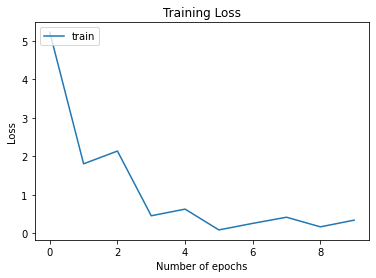

In [94]:
plt.plot(tr_loss_hist)
plt.title('Training Loss')
plt.ylabel('Loss')
plt.xlabel('Number of epochs')
plt.legend(['train'], loc='upper left')
plt.show()

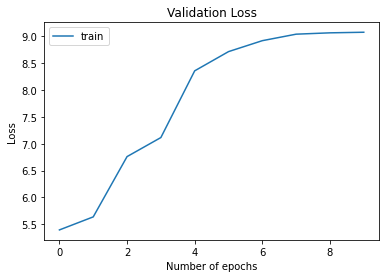

In [95]:
plt.plot(v_loss_hist)
plt.title('Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Number of epochs')
plt.legend(['train'], loc='upper left')
plt.show()

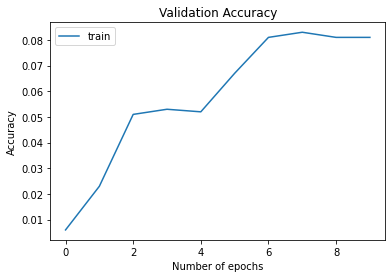

In [96]:
plt.plot(v_acc_hist)
plt.title('Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Number of epochs')
plt.legend(['train'], loc='upper left')
plt.show()

In [97]:
"""
Tests model accuracy with test images
"""
start = time.time()
total = 0
correct = 0
acc_hist = list()
tot_hist = list()
with torch.no_grad():
    for data in testLoad:
        images, labels = data
        outputs = model(images)
        _, guess = torch.max(outputs.data, 1) 
        total = total + labels.size(0) #total num of images
        correct = correct + (guess == labels).sum().item() #number correct
        acc_hist.append(correct)
        tot_hist.append(total)
end = time.time()
print("Total images tested in model:", len(testLabels))
print("Total accurate predictions:", correct)
print(f"Accuracy of model w/ full test dataset fed: {round(100 * correct / total,8)}%")
print("Testing time in seconds:", end - start)

Total images tested in model: 8041
Total accurate predictions: 6379
Accuracy of model w/ full test dataset fed: 79.33092899%
Testing time in seconds: 1194.548089981079


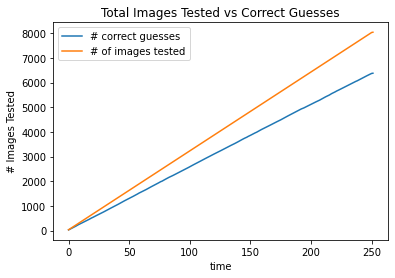

In [98]:
plt.plot(acc_hist)
plt.plot(tot_hist)
plt.title('Total Images Tested vs Correct Guesses')
plt.ylabel('# Images Tested')
plt.xlabel('time')
plt.legend(['# correct guesses', '# of images tested'], loc='upper left')
plt.show()

In [99]:
def find_classes(dir):
    classes = os.listdir(dir)
    classes.sort()
    class_to_idx = {classes[i]: i for i in range(len(classes))}
    return classes, class_to_idx
classes, idx = find_classes(processed_test_dir_path)

def predict(image, model, topk=5):
    #open image and change to np form//cpu consideration
    pil_in = PIL.Image.open(image)
    transform = transforms.Compose([transforms.Resize((244,244)),
                                    transforms.CenterCrop(224),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406], 
                                                         [0.229, 0.224, 0.225])])
    pilTrans = transform(pil_in)
    img = np.array(pilTrans)
    img_tensor = torch.from_numpy(img).type(torch.FloatTensor) #np to tensor
    dimen = img_tensor.unsqueeze_(0)
    model.eval()
    with torch.no_grad():
        output = model.forward(dimen)
    probs_top = output.topk(topk)[0]
    top_prediction = output.topk(topk)[1]
    p = np.array(top_prediction)[0]
    o_guesses = np.array(top_prediction)[0]
    return p, o_guesses

Randomly chosen file to classify: ./Data/Car-Images/Bounded-Test-Images/06890.jpg
Seconds elapsed for prediction: 0.13313674926757812
*******************************
FIRST GUESS:  Mercedes-Benz E-Class Sedan 2012
*******************************
Might also be: Mercedes-Benz S-Class Sedan 2012
Might also be: Mercedes-Benz SL-Class Coupe 2009
Might also be: BMW M3 Coupe 2012
Might also be: Aston Martin Virage Convertible 2012 



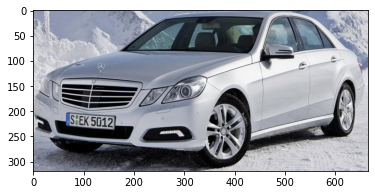

In [117]:
# Results using trained model!

random_test_image = str(str(randint(1, len(testLabels))).zfill(5)) + '.jpg'
image_to_classify = "./Data/Car-Images/Bounded-Test-Images/" + random_test_image
device = ('cpu')
start = time.time()
tp, ps = predict(image_to_classify, model, topk=5)

print("Randomly chosen file to classify:",image_to_classify)
end = time.time()
print("Seconds elapsed for prediction:", end - start)

print("*******************************")
print("FIRST GUESS: ",classes[ps[0]])
print("*******************************")

print("Might also be:", classes[ps[1]])
print("Might also be:", classes[ps[2]])
print("Might also be:", classes[ps[3]])
print("Might also be:", classes[ps[4]], "\n")

gimg = mpimg.imread(image_to_classify)
imshow(gimg)

In [131]:
# Save the torch Model using the torch.save()
torch.save(model, "./resnet_model.py")

In [133]:
# Load the saved model
saved_model = torch.load("./resnet_model.py")

Randomly chosen file to classify: ./Data/Car-Images/Bounded-Test-Images/00554.jpg
Seconds elapsed for prediction: 0.13168096542358398
*******************************
FIRST GUESS: AM General Hummer SUV 2000
*******************************
Might also be: Jeep Wrangler SUV 2012
Might also be: HUMMER H3T Crew Cab 2010
Might also be: Chevrolet Silverado 1500 Regular Cab 2012
Might also be: HUMMER H2 SUT Crew Cab 2009 



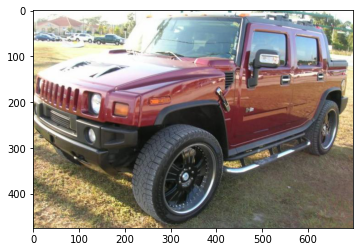

In [153]:
# Results using Pickled Model
random_test_image = str(str(randint(1, len(testLabels))).zfill(5)) + '.jpg'
image_to_classify = "./Data/Car-Images/Bounded-Test-Images/" + random_test_image
device = ('cpu')
start = time.time()
tp, ps = predict(image_to_classify, saved_model, topk=5)

print("Randomly chosen file to classify:",image_to_classify)
end = time.time()
print("Seconds elapsed for prediction:", end - start)

print("*******************************")
print("FIRST GUESS:", classes[ps[0]])
print("*******************************")

print("Might also be:", classes[ps[1]])
print("Might also be:", classes[ps[2]])
print("Might also be:", classes[ps[3]])
print("Might also be:", classes[ps[4]], "\n")

gimg = mpimg.imread(image_to_classify)
imshow(gimg)

### Project by
1. Mayank Yadav
2. Akash Maggon
3. Akshat 